In [1]:
import torch
from models import BCDnet
import numpy as np

from utils import od2rgb, rgb2od, direct_deconvolution
import matplotlib.pyplot as plt

from datasets import WSSBDatasetTest

In [2]:
weights_dict = torch.load('/work/work_fran/Deep_Var_BCD/weights/best_weights_icip/best.pt')

In [3]:
model = BCDnet(cnet_name='unet_64_6', mnet_name='mobilenetv3s_50')
model.load_state_dict(weights_dict)

<All keys matched successfully>

In [4]:
dataset = WSSBDatasetTest('/data/datasets/Alsubaie/Data/', organ_list=['Colon'], load_at_init=False)

[WSSBDataset] Scanning files...
[WSSBDataset] Done scanning files


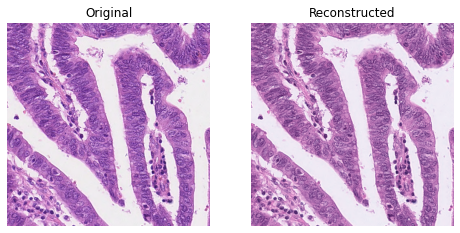

In [5]:
img, M_gt = dataset[3]
img_np = img.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
img_od = rgb2od(img)
M_mean, M_var, C_mean = model(img_od.unsqueeze(0)) # (1, 3, 2), (1, 1, 2), (1, 2, 224, 224)
M_mean = M_mean.detach().cpu()
M_var = M_var.detach().cpu()
C_mean = C_mean.detach().cpu()

img_rec_od = torch.einsum('bcs,bshw->bchw', M_mean, C_mean) # (1, 3, 224, 224)
img_rec = torch.clamp(od2rgb(img_rec_od), 0.0, 255.0)
img_rec_np = img_rec.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_np)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(img_rec_np)
ax[1].set_title('Reconstructed')
ax[1].axis('off')
plt.show()

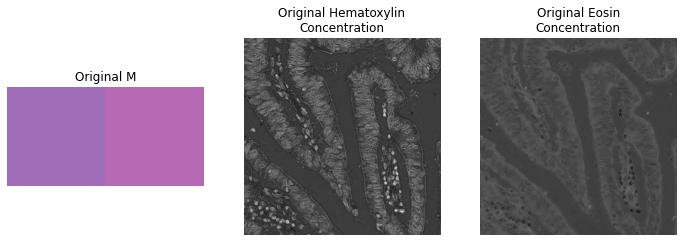

In [6]:
C_gt = direct_deconvolution(img_od, M_gt)
M_gt = M_gt.unsqueeze(0) # (1, 3, 2)
C_gt = C_gt.unsqueeze(0) # (1, 2, 224, 224)

M_gt_rgb = torch.clamp(od2rgb(M_gt / np.log(256)), 0.0, 255.0) # (1, 3, 2)
M_gt_rgb_np = M_gt_rgb.squeeze().detach().cpu().numpy().transpose(1, 0).astype('int') # (2, 3)

C_H_gt_od = C_gt[:, 0, :, :].squeeze() # (224, 224)
C_H_gt = torch.clamp(od2rgb(C_H_gt_od), 0.0, 255.0)
C_H_gt_np = C_gt[:, 0, :, :].squeeze().numpy() # (224, 224)

C_E_gt_od = C_gt[:, 1, :, :].squeeze() # (224, 224)
C_E_gt = torch.clamp(od2rgb(C_E_gt_od), 0.0, 255.0)
C_E_gt_np = C_gt[:, 1, :, :].squeeze().numpy() # (224, 224)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(np.expand_dims(M_gt_rgb_np, axis=0))
ax[0].set_title('Original M')
ax[0].axis('off')

ax[1].imshow(C_H_gt_np, cmap='gray')
ax[1].set_title('Original Hematoxylin\nConcentration')
ax[1].axis('off')

ax[2].imshow(C_E_gt_np, cmap='gray')
ax[2].set_title('Original Eosin\nConcentration')
ax[2].axis('off')
plt.show()

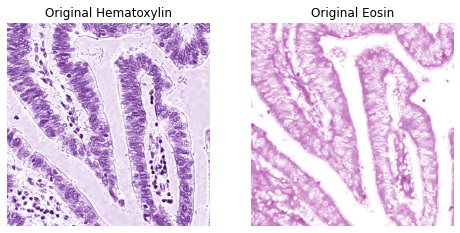

In [7]:
H_gt_od = torch.einsum('bcs,bshw->bschw', M_gt, C_gt)[:,0,:,:] # (batch_size, H, W)
H_gt = torch.clamp(od2rgb(H_gt_od), 0.0, 255.0) # (batch_size, 3, H, W)
E_gt_od = torch.einsum('bcs,bshw->bschw', M_gt, C_gt)[:,1,:,:] # (batch_size, H, W)
E_gt = torch.clamp(od2rgb(E_gt_od), 0.0, 255.0) # (batch_size, 3, H, W)

H_gt_np = H_gt.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
E_gt_np = E_gt.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(H_gt_np)
ax[0].set_title('Original Hematoxylin')
ax[0].axis('off')

ax[1].imshow(E_gt_np)
ax[1].set_title('Original Eosin')
ax[1].axis('off')

plt.show()

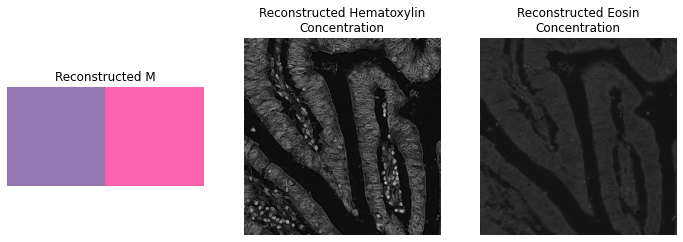

In [8]:
M_rec_rgb = torch.clamp(od2rgb(M_mean / np.log(256)), 0.0, 255.0) # (1, 3, 2)
M_rec_rgb_np = M_rec_rgb.squeeze().detach().cpu().numpy().transpose(1, 0).astype('int') # (2, 3)

C_H_rec_od = C_mean[:, 0, :, :].squeeze() # (224, 224)
C_H_rec = torch.clamp(od2rgb(C_H_rec_od), 0.0, 255.0)
C_H_rec_np = C_mean[:, 0, :, :].squeeze().numpy() # (224, 224)

C_E_rec_od = C_mean[:, 1, :, :].squeeze() # (224, 224)
C_E_rec = torch.clamp(od2rgb(C_E_rec_od), 0.0, 255.0)
C_E_rec_np = C_mean[:, 1, :, :].squeeze().numpy() # (224, 224)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(np.expand_dims(M_rec_rgb_np, axis=0))
ax[0].set_title('Reconstructed M')
ax[0].axis('off')

ax[1].imshow(C_H_rec_np, cmap='gray')
ax[1].set_title('Reconstructed Hematoxylin\nConcentration')
ax[1].axis('off')

ax[2].imshow(C_E_rec_np, cmap='gray')
ax[2].set_title('Reconstructed Eosin\nConcentration')
ax[2].axis('off')
plt.show()

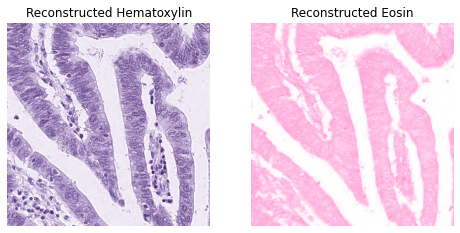

In [9]:
H_rec_od = torch.einsum('bcs,bshw->bschw', M_mean, C_mean)[:,0,:,:] # (batch_size, H, W)
H_rec = torch.clamp(od2rgb(H_rec_od), 0.0, 255.0) # (batch_size, 3, H, W)
E_rec_od = torch.einsum('bcs,bshw->bschw', M_mean, C_mean)[:,1,:,:] # (batch_size, H, W)
E_rec = torch.clamp(od2rgb(E_rec_od), 0.0, 255.0) # (batch_size, 3, H, W)

H_rec_np = H_rec.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
E_rec_np = E_rec.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(H_rec_np)
ax[0].set_title('Reconstructed Hematoxylin')
ax[0].axis('off')

ax[1].imshow(E_rec_np)
ax[1].set_title('Reconstructed Eosin')
ax[1].axis('off')

plt.show()

In [16]:
from engine import evaluate_GT

wssb_dataloader_dic = {}
for organ in ['Lung', 'Breast', 'Colon']:
    wssb_dataset = WSSBDatasetTest('/data/datasets/Alsubaie/Data/', organ_list=[organ], load_at_init=False)
    wssb_dataloader_dic[organ] = torch.utils.data.DataLoader(wssb_dataset, batch_size=1, shuffle=False)

metrics_organ = {}
for organ in ['Lung', 'Breast', 'Colon']:
    m = evaluate_GT(model, wssb_dataloader_dic[organ], sigma_rui_sq=0.05, theta_val=0.3, device='cpu')
    metrics_organ[organ] = m
metrics = {}
metrics_list = metrics_organ['Lung'].keys()

for metric in metrics_list:
    metrics[f'test/wssb/{metric}'] = np.mean([metrics_organ[organ][metric] for organ in metrics_organ])
    for organ in metrics_organ:
        metrics[f'test/wssb/{organ}/{metric}'] = m[metric]

[WSSBDataset] Scanning files...
[WSSBDataset] Done scanning files
[WSSBDataset] Scanning files...
[WSSBDataset] Done scanning files
[WSSBDataset] Scanning files...
[WSSBDataset] Done scanning files


Test:   0%|          | 0/4 [00:00<?, ?it/s]

Test: 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


In [17]:
psnr_metrics = [m for m in metrics.keys() if 'psnr' in m]
for metric in psnr_metrics:
        print('{:<25s}: {:s}'.format(metric, str(metrics[metric])))

test/wssb/psnr_rec       : 30.435927519722586
test/wssb/Lung/psnr_rec  : 31.070590564182826
test/wssb/Breast/psnr_rec: 31.070590564182826
test/wssb/Colon/psnr_rec : 31.070590564182826
test/wssb/psnr_gt_h      : 25.983133384159633
test/wssb/Lung/psnr_gt_h : 25.03680964878627
test/wssb/Breast/psnr_gt_h: 25.03680964878627
test/wssb/Colon/psnr_gt_h: 25.03680964878627
test/wssb/psnr_gt_e      : 23.532777089921257
test/wssb/Lung/psnr_gt_e : 22.548154967171804
test/wssb/Breast/psnr_gt_e: 22.548154967171804
test/wssb/Colon/psnr_gt_e: 22.548154967171804
test/wssb/psnr_gt        : 24.757955237040445
test/wssb/Lung/psnr_gt   : 23.79248230797904
test/wssb/Breast/psnr_gt : 23.79248230797904
test/wssb/Colon/psnr_gt  : 23.79248230797904
